In [30]:
import math 
import torch 
import numpy as np 
import networkx as nx
from torch_geometric.data import Data, Dataset
import os
import matplotlib.pyplot as plt
import glob
from pathlib import Path

from tqdm import tqdm
import pulser as pl
import rdkit
import qek.data.graphs as qek_graphs

from qek.shared.error import CompilationError
from image_to_graph import load_image, superpixel_to_graph, pixel_to_graph, visualize_graph_with_texture
from graph_to_register import graph_to_quantum_register, visualize_register_with_connections

import os

from image_graph_dataset import ImageGraphDataset
from compatibility_utils import make_compatible_with_analog_device

# 1) Prepare the dataset

- Graph generation  
- Assign features to edges and nodes
- Assign target value (based on it's density)

In [31]:
# Specify the directory 
img_dir = os.path.join(os.getcwd(), '..', 'dataset')
print(img_dir)

# Create the dataset from images (with texture features)
dataset = ImageGraphDataset(
    img_dir=img_dir,
    max_samples=20,
    n_segments=20,          # Number of superpixels
    use_superpixels=True
)

print(f"""
------------- Dataset created -------------

    - Total Graphs: {len(dataset)}
    - Sample Graph: {dataset[0]}
    
-------------------------------------------
    """)



/home/nuno/Desktop/GIC-quAI-Pasqal/src/main_pipeline/../dataset
Found 16 images in /home/nuno/Desktop/GIC-quAI-Pasqal/src/main_pipeline/../dataset


Converting images to graphs: 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]

Successfully created 16 graphs

------------- Dataset created -------------

    - Total Graphs: 16
    - Sample Graph: Data(
  x=[22, 17],
  edge_index=[2, 106],
  pos=[22, 2],
  texture_info={
    has_texture=True,
    feature_dims={
      color=3,
      lbp_hist=10,
      glcm=4,
    },
  },
  filename='test.jpeg',
  y=[1]
)
    
-------------------------------------------
    


# 2) Compile a register and a pulse

In [32]:
# Prepare graphs for compilation
graphs_to_compile = []
original_data = []  # Store the original data separately for later reference

for i, data in enumerate(tqdm(dataset)):
    try:
        # Make the graph compatible with AnalogDevice
        compatible_data = make_compatible_with_analog_device(data)
        original_data.append(compatible_data)  # Store the compatible version for later
        
        # Create BaseGraph - Note: BaseGraph stores data in pyg attribute, not data
        graph = qek_graphs.BaseGraph(
            id=i,
            data=compatible_data,
            device=pl.AnalogDevice
        )
        graph.target = compatible_data.y.item()
        graphs_to_compile.append(graph)
    except ValueError as e:
        print(f"Graph {i} could not be made compatible: {str(e)}")
    except Exception as e:
        print(f"Unexpected error with graph {i}: {str(e)}")


100%|██████████| 16/16 [00:00<00:00, 249.83it/s]


In [33]:

    
# Compile graphs to pulse and register
compiled = []

for i, graph in enumerate(tqdm(graphs_to_compile)):
    try:
        # Access the graph data from original_data which preserves the texture info
        # BaseGraph stores minimal information and doesn't have all attributes
        
        # Custom register compilation using our texture-aware function
        original_graph_data = original_data[i]
        custom_register = graph_to_quantum_register(
            original_graph_data, 
            texture_feature="pca",
            scale_factor=5
        )
        
        # Assign the register to the graph and compile pulse
        register = custom_register  # Use our custom register
        graph.register = register   # Assign it to the graph
        pulse = graph.compile_pulse()
        
        # Store the successful compilation
        compiled.append((graph, original_graph_data, pulse))
    except CompilationError as e:
        # Skip
        print(f"Graph {graph.id} failed compilation. Error: {e}")
    except Exception as e:
        print(f"Unexpected error during compilation for graph {graph.id}: {str(e)}")
        
print(f"Compiled {len(compiled)} graphs out of {len(graphs_to_compile)}.")
        
# Visualize a compiled register with texture information
if len(compiled) > 0:
    sample_idx = 0
    sample_compiled_graph, sample_original_data, sample_pulse = compiled[sample_idx]
    
    # Visualize the quantum register with connections
    register_fig = visualize_register_with_connections(
        sample_compiled_graph.register, 
        graph_data=sample_original_data,
        title=f"Quantum Register from {getattr(sample_original_data, 'filename', 'unknown')}"
    )
    register_fig.savefig(os.path.join(os.path.dirname(img_dir), 'register_visualization.png'))
    plt.close(register_fig)
    
    print(f"Register visualization saved to {os.path.join(os.path.dirname(img_dir), 'register_visualization.png')}")

  0%|          | 0/16 [00:00<?, ?it/s]

Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 30.04% of texture variation
Creating register with 22 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 30.04% of texture variation
Creating register with 22 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 30.04% of texture variation
Creating register with 22 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 30.04% of texture variation
Creating register with 22 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 44.26% of texture variation
Creating register with 14 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 44.26% of texture variation
Creating register with 14 atom

100%|██████████| 16/16 [00:00<00:00, 80.91it/s]


PCA first component explains 28.98% of texture variation
Creating register with 18 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 44.26% of texture variation
Creating register with 14 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 32.12% of texture variation
Creating register with 21 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 28.98% of texture variation
Creating register with 18 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 32.12% of texture variation
Creating register with 21 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit device constraints
PCA first component explains 32.12% of texture variation
Creating register with 21 atoms (max allowed: 80)
Reducing scale factor from 5 to 1.00 to fit

(<qek.data.graphs.BaseGraph object at 0x7709d38a60b0>, Data(
  x=[22, 17],
  edge_index=[2, 106],
  pos=[22, 2],
  texture_info={
    has_texture=True,
    feature_dims={
      color=3,
      lbp_hist=10,
      glcm=4,
    },
  },
  filename='test copy 2.jpeg',
  y=[1]
), Pulse(amp=ConstantWaveform(660 ns, 6.28) rad/µs, detuning=RampWaveform(660 ns, 0->0) rad/µs, phase=0, post_phase_shift=0))


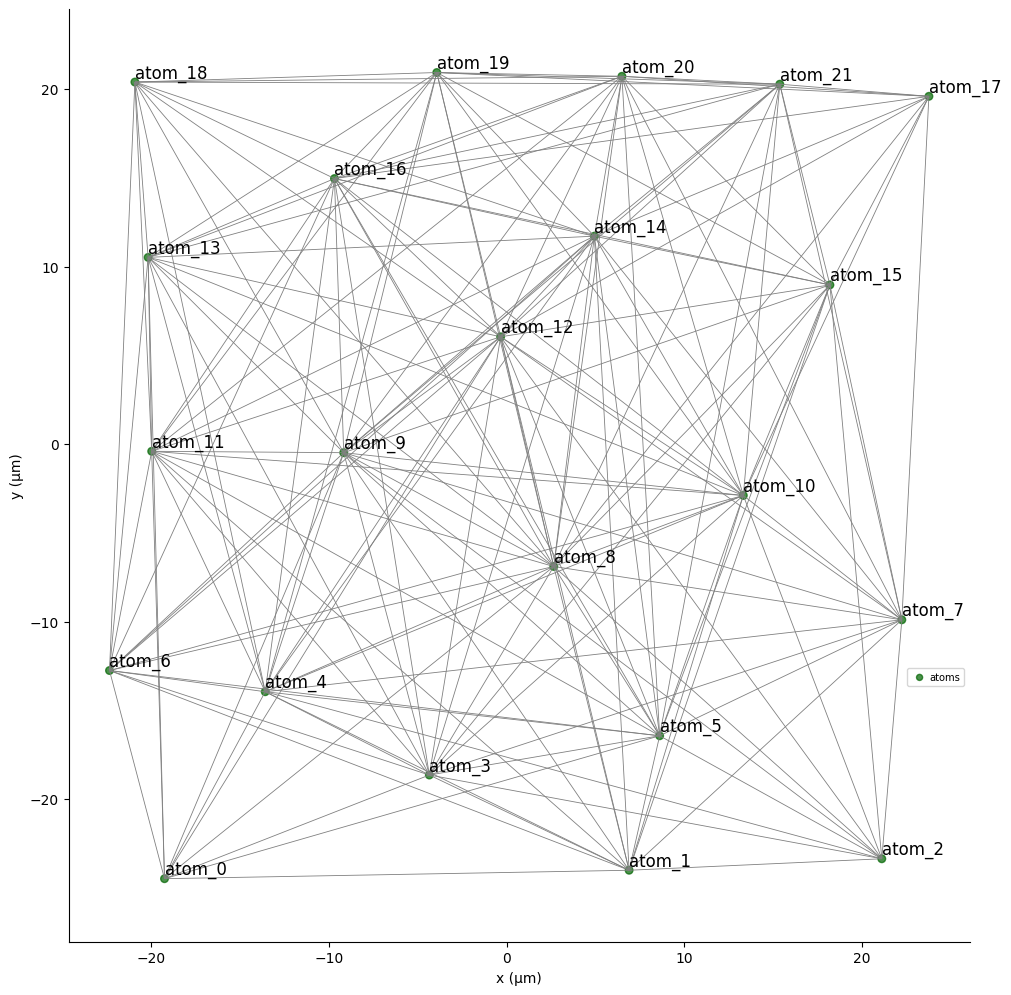

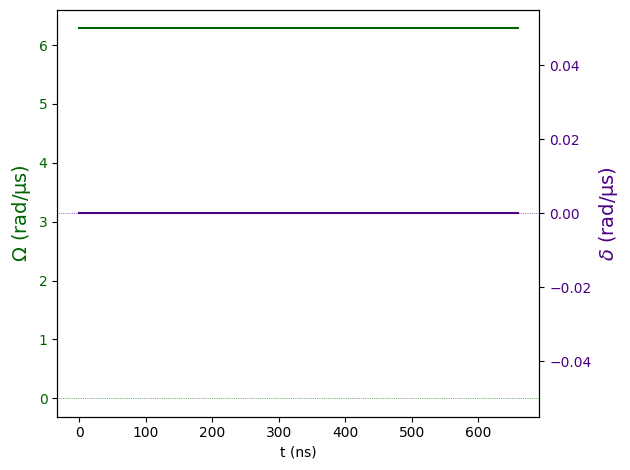

: 

In [ ]:

print(compiled[2])
example_graph, example_data, example_pulse = compiled[2]
example_register = example_graph.register
example_register.draw(blockade_radius=pl.AnalogDevice.max_radial_distance + 0.01)
example_pulse.draw()

# 3) Execution

In [ ]:
"""
EXECUTING ON AN EMULATOR
"""

from qek.data.processed_data import ProcessedData
from qek.backends import QutipBackend

processed_dataset = []
executor = QutipBackend(device=pl.AnalogDevice)
for graph, original_data, pulse in tqdm(compiled):
    states = await executor.run(register=graph.register, pulse=pulse)
    processed_dataset.append(ProcessedData.from_register(
        register=register,
        pulse=pulse,
        device=pl.AnalogDevice,
        state_dict=states,
        target=graph.target
    ))

  0%|          | 0/16 [00:00<?, ?it/s]


    Total number of samples: 12
    Example state_dict {'0000': 3, '0001': 12, '0010': 8, '0011': 33, '0100': 6, '0101': 27, '0110': 24, '0111': 106, '1000': 8, '1001': 34, '1010': 34, '1011': 117, '1100': 34, '1101': 114, '1110': 103, '1111': 337}    



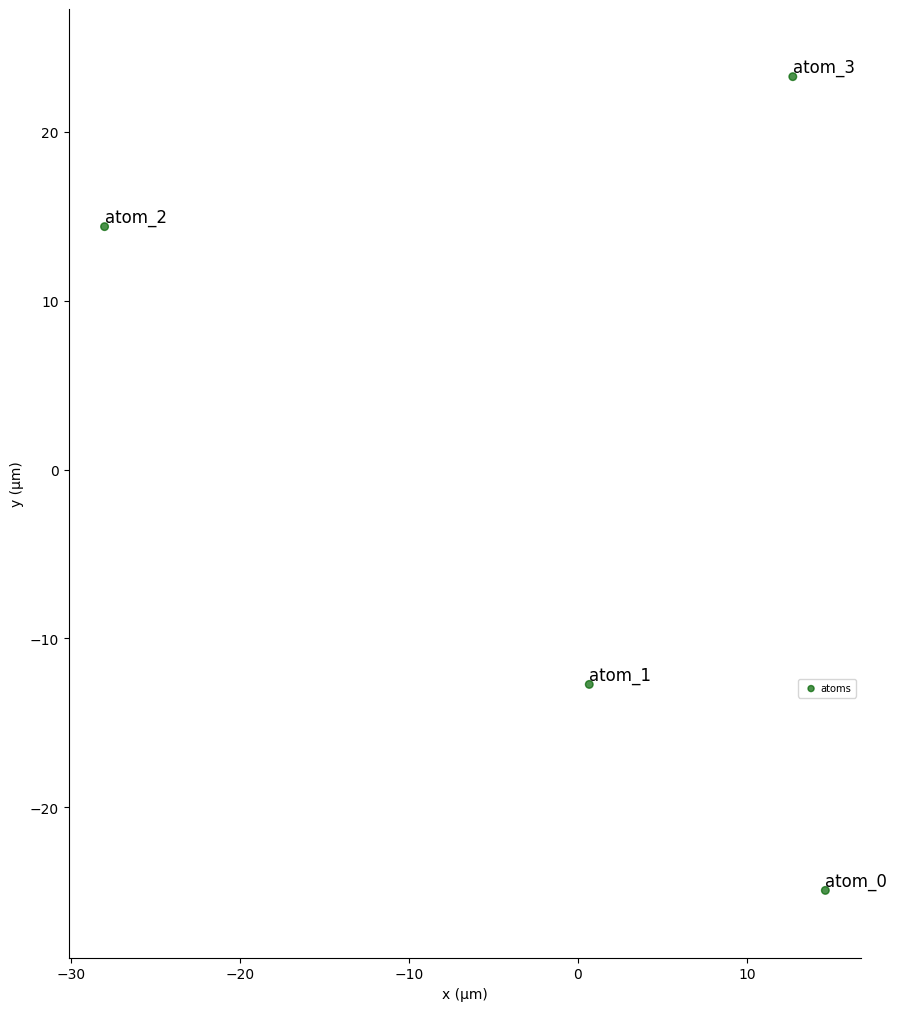

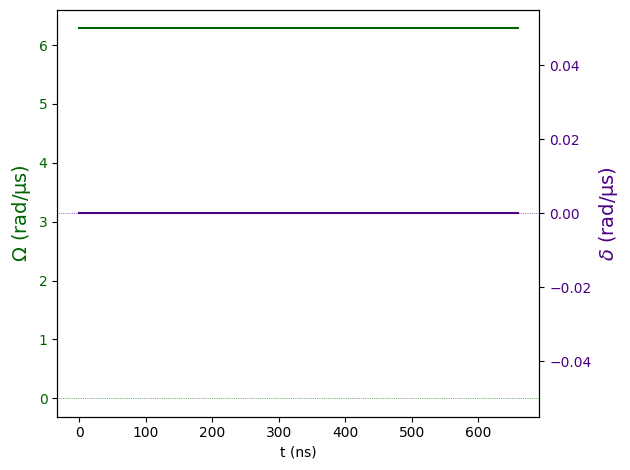

In [ ]:
dataset_example: ProcessedData = processed_dataset[0]
print(f"""
    Total number of samples: {len(processed_dataset)}
    Example state_dict {dataset_example.state_dict}    
""")

dataset_example.draw_register()
dataset_example.draw_pulse()
display()

# 4) Extract QEK features for machine learning

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare features (X) and targets (y)
X = [data for data in processed_dataset]
y = [data.target for data in processed_dataset]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    stratify=y,
    test_size=0.2, 
    random_state=42
)

print(f"Size of the training quantum compatible dataset = {len(X_train)}")
print(f"Size of the testing quantum compatible dataset = {len(X_test)}")


Size of the training quantum compatible dataset = 9
Size of the testing quantum compatible dataset = 3


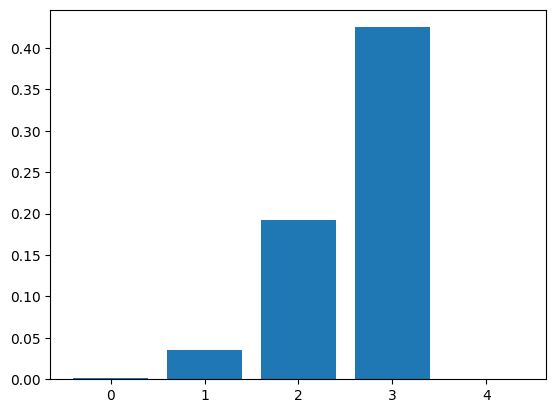

In [ ]:
X_train[0].draw_excitation()

In [ ]:
from qek.kernel import QuantumEvolutionKernel as QEK 

# The Quantum Evolution Kernel will be used to compute a similarity score between 2 graphs

# Initialize the Quantum Evolution Kernel with a hyperparameter mu
kernel = QEK(mu=0.5)

# Fit the kernel to the training data
# This means that the kernel will learn the optimal parameters for the kernel
kernel.fit(X_train)

# Transform
K_train = kernel.transform(X_train)
K_test = kernel.transform(X_test)

print(f"Training Kernel Matrix Shape: {K_train.shape}")
print(f"Testing Kernel Matrix Shape: {K_test.shape}")

Training Kernel Matrix Shape: (9, 9)
Testing Kernel Matrix Shape: (3, 9)


# 5) Train the Machine Learning Model (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC

# Define a Support Vector Machine classifier with the Quantum Evolution Kernel
qek_kernel = QEK(mu=0.5)
model = SVC(kernel=qek_kernel, random_state=42)

In [ ]:
model.fit(X_train, y_train)

SVC(kernel=<qek.kernel.kernel.FastQEK object at 0x7709d11d6980>,
    random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score

print("\nEvaluation Results:")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")


Evaluation Results:
F1 Score: 0.5333333333333333
Balanced Accuracy Score: 0.5
